# Downloading Dataset

In [7]:
from bs4 import BeautifulSoup
import requests
import os

In [43]:
domain = 'https://raw.githubusercontent.com/balajisrinivas/Face-Mask-Detection/master/dataset/' 
path = 'https://github.com/balajisrinivas/Face-Mask-Detection/tree/master/dataset/'
categories = ['with_mask','without_mask']
des_loc = os.path.join(os.curdir,'dataset')

In [5]:
import os
import numpy as np

In [6]:
DIRECTORY = os.path.join(os.curdir,'dataset')
CATEGORIES = ['with_mask','without_mask']

In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model

## Data Loading and Preprocessing

In [4]:
# learning rate
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [5]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY,category)
    for img in os.listdir(path):
        img_path = os.path.join(path,img)
        image = load_img(img_path,target_size=(224,224))
        image = img_to_array(image)
        image = keras.applications.xception.preprocess_input(image)
        
        data.append(image)
        labels.append(category)

In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
data = np.array(data, dtype = 'float32')

In [7]:
# splitting to training and testing set
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=.2, stratify=labels, random_state=17)

### Augmenting the dataset for better performance

In [8]:
aug = ImageDataGenerator(
           rotation_range = 20,
           zoom_range = 0.15,
           width_shift_range = 0.2,
           height_shift_range = 0.2,
           shear_range = 0.15,
           horizontal_flip = True,
           fill_mode = 'nearest')

### Model Construction
###### --- Prefering Transfer Learning 

In [9]:
baseModel = keras.applications.xception.Xception(weights='imagenet',include_top=False)

In [10]:
headModel = baseModel.output
headModel = keras.layers.GlobalAveragePooling2D()(headModel) #pool_size = (7,7)
headModel = Dense(2, activation = 'softmax')(headModel) 

In [11]:
model = Model(inputs = baseModel.input , outputs = headModel)

In [12]:
# freezing weights in the base layers
for layer in baseModel.layers:
    layer.trainable = False

In [13]:
opt = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay = 0.01)

model.compile(loss = 'binary_crossentropy' ,optimizer = opt , metrics = ['accuracy'])

### Training

In [14]:
H = model.fit(aug.flow(trainX,trainY,batch_size=32),validation_data=(testX,testY),epochs=5)

Epoch 1/5
50/50 [==============================] - 250s 5s/step - loss: 0.0636 - accuracy: 0.9779 - val_loss: 0.0508 - val_accuracy: 0.9874
Epoch 2/5
50/50 [==============================] - 280s 6s/step - loss: 0.0172 - accuracy: 0.9912 - val_loss: 0.0249 - val_accuracy: 0.9924
Epoch 3/5
50/50 [==============================] - 211s 4s/step - loss: 0.0236 - accuracy: 0.9937 - val_loss: 0.0343 - val_accuracy: 0.9899
Epoch 4/5
50/50 [==============================] - 277s 6s/step - loss: 0.0128 - accuracy: 0.9950 - val_loss: 0.0307 - val_accuracy: 0.9899
Epoch 5/5
50/50 [==============================] - 282s 6s/step - loss: 0.0112 - accuracy: 0.9962 - val_loss: 0.0341 - val_accuracy: 0.9899


### plotting the accuraccy and losses over training epochs

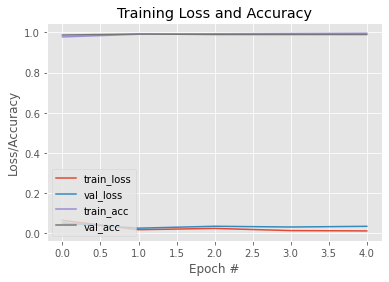

In [15]:
N = 5
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

### For faster detection consider converting to tflite

In [19]:
import tensorflow as tf

In [20]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\atp17\AppData\Local\Temp\tmp2kp41ld9\assets


C:\Users\atp17\Anaconda3\envs\ml_env\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [21]:
with open('mask_model.tflite', 'wb') as f:
    f.write(tflite_model)